<h1>ASTM to TBP Conversion Using Linear Regression</h1>

I'm trying to convert ASTM D1160 to TBP for works and I simply didn't know how. So I did some reasearch, and found this paper published in 2015. https://www.vurup.sk/wp-content/uploads/dlm_uploads/2017/07/pc_3_2015_stratiev_354_0.pdf

In it, it shows comparison on ASTM D1160 conversion to TBP using several methods. The least error method was using Linear Regression employed by Lukoil Neftochim Bourgas. The paper has shown the linear regression coefficient that they have obtained for each wt% of the data. But it stopped short at 80%. I want to replicate their method using linear regression but the paper simply has limited data. I see this as opportunity for me to try syntethic data generation that is used by data scientist. A good weekend project. 

In [1]:
#first let us load our library and packages (comon ones)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#then let's load the data 
df = pd.read_csv('/kaggle/input/astmdata/ASTMData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   No         60 non-null     int64
 1   D1160_90   60 non-null     int64
 2   Target_90  60 non-null     int64
 3   D1160_95   60 non-null     int64
 4   Target_95  60 non-null     int64
dtypes: int64(5)
memory usage: 2.5 KB


The data has 4 columns, with 60 rows. 2 rows represents 90 wt% and the other 2 represents 95 wt%.  Since I want to perform linear regression for each, i need to separate this df into two

In [3]:
#separate into two
df90 = df.drop(['No','D1160_95','Target_95'],axis=1)
df95 = df.drop(['No','D1160_90','Target_90'],axis=1)

df90.info()
df95.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   D1160_90   60 non-null     int64
 1   Target_90  60 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   D1160_95   60 non-null     int64
 1   Target_95  60 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


In [4]:
#alright let's do some linear regression to show how low our score
#import sklearn library first
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#set our X and y
X90 = df90.drop('Target_90',axis=1)
y90 =df90['Target_90']

X95 = df95.drop('Target_95',axis=1)
y95 =df95['Target_95']

#split our data
X90_train,X90_test,y90_train,y90_test = train_test_split(X90,y90,test_size= 0.08,random_state =527)
X95_train,X95_test,y95_train,y95_test = train_test_split(X95,y95,test_size= 0.08,random_state =527)

#fit the data to model
reg90 =LinearRegression()
reg90.fit(X90_train,y90_train)

reg95 =LinearRegression()
reg95.fit(X95_train,y95_train)


LinearRegression()

In [5]:
#let's look at the accuracy
#make predictions
pred90 = reg90.predict(X90_test)
pred95 = reg95.predict(X95_test)

#check accuracy
from sklearn.metrics import r2_score,mean_squared_error

r290 = r2_score(pred90,y90_test)
mse90 =mean_squared_error(pred90,y90_test)

r295 = r2_score(pred95,y95_test)
mse95 =mean_squared_error(pred95,y95_test)


print(f"The R2 score for 90 wt% is {r290:0.04f}")
print(f"The mean squared error for 90 wt% is {mse90:0.04f}")

print(f"The R2 score for 95 wt% is {r295:0.04f}")
print(f"The mean squared error for 95 wt% is {mse95:0.04f}")



The R2 score for 90 wt% is 0.3327
The mean squared error for 90 wt% is 9583.2406
The R2 score for 95 wt% is 0.9535
The mean squared error for 95 wt% is 616.6729


Alright, seems like the score is too low. This is where we use data augmentation to hopefully improve the score. Since we don't have enough data.

In [6]:
#let's create a function to augment our data


def augment_data(row):
    # Adding random noise to numerical columns
    for column in row.index:
        if pd.api.types.is_numeric_dtype(row[column]):
            row[column] += np.random.normal(3, 2.5)  # Adjust the parameters as needed

    return row


In [7]:
#now let's apply the function

# Apply data augmentation to the existing rows
df90_augment = df90.sample(n=200, replace=True).apply(augment_data, axis=1)
df95_augment = df95.sample(n=200, replace=True).apply(augment_data, axis=1)

# Combine original and augmented data
df90_new = pd.concat([df90, df90_augment], ignore_index=True)
df95_new = pd.concat([df95, df95_augment], ignore_index=True)

df90_new.info()
df95_new.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   D1160_90   260 non-null    float64
 1   Target_90  260 non-null    float64
dtypes: float64(2)
memory usage: 4.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   D1160_95   260 non-null    float64
 1   Target_95  260 non-null    float64
dtypes: float64(2)
memory usage: 4.2 KB


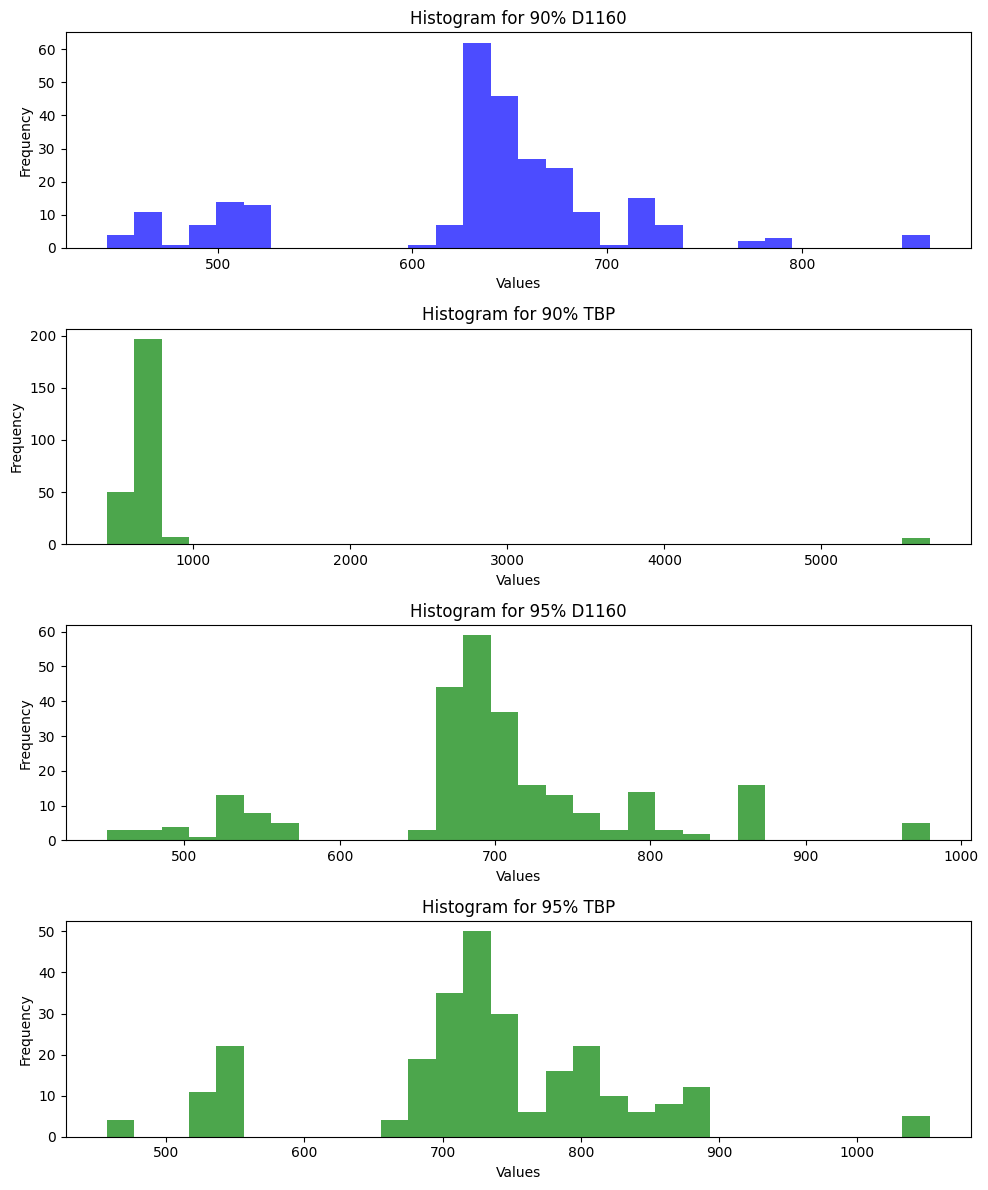

In [8]:
#let's look at our data, whether it has been augmented properly. 
# Plot histograms for each column
plt.figure(figsize=(10, 12))

# Histogram for D1160 90 wt%
plt.subplot(4, 1, 1)
plt.hist(df90_new['D1160_90'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram for 90% D1160')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogram for TBP 90 wt%
plt.subplot(4, 1, 2)
plt.hist(df90_new['Target_90'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 90% TBP')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogram for TBP 90 wt%
plt.subplot(4, 1, 3)
plt.hist(df95_new['D1160_95'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 95% D1160')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.subplot(4, 1, 4)
plt.hist(df95_new['Target_95'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 95% TBP')
plt.xlabel('Values')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [9]:
#alright, seems like we have to move some outliers of data.

#get data outliers using six sigma
a90= np.mean(df90_new['D1160_90'])+(3*np.std(df90_new['D1160_90']))
b90 = np.mean(df90_new['Target_90'])+(3*np.std(df90_new['Target_90']))

a95= np.mean(df95_new['D1160_95'])+(3*np.std(df95_new['D1160_95']))
b95 = np.mean(df95_new['Target_95'])+(3*np.std(df95_new['Target_95']))

c90= np.mean(df90_new['D1160_90'])-(3*np.std(df90_new['D1160_90']))
d90 = np.mean(df90_new['Target_90'])-(3*np.std(df90_new['Target_90']))

c95= np.mean(df95_new['D1160_95'])-(3*np.std(df95_new['D1160_95']))
d95 = np.mean(df95_new['Target_95'])-(3*np.std(df95_new['Target_95']))

df90_new = df90_new.loc[(df90_new['D1160_90']>c90) & 
                        (df90_new['D1160_90']<a90) & 
                        (df90_new['Target_90']>d90) &
                        (df90_new['Target_90']<b90)]

df95_new = df95_new.loc[(df95_new['D1160_95']>c95) & 
                        (df95_new['D1160_95']<a95) & 
                        (df95_new['Target_95']>d95) &
                        (df95_new['Target_95']<b95)]



df90_new.info()
df95_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 0 to 259
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   D1160_90   254 non-null    float64
 1   Target_90  254 non-null    float64
dtypes: float64(2)
memory usage: 6.0 KB
<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 0 to 259
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   D1160_95   255 non-null    float64
 1   Target_95  255 non-null    float64
dtypes: float64(2)
memory usage: 6.0 KB


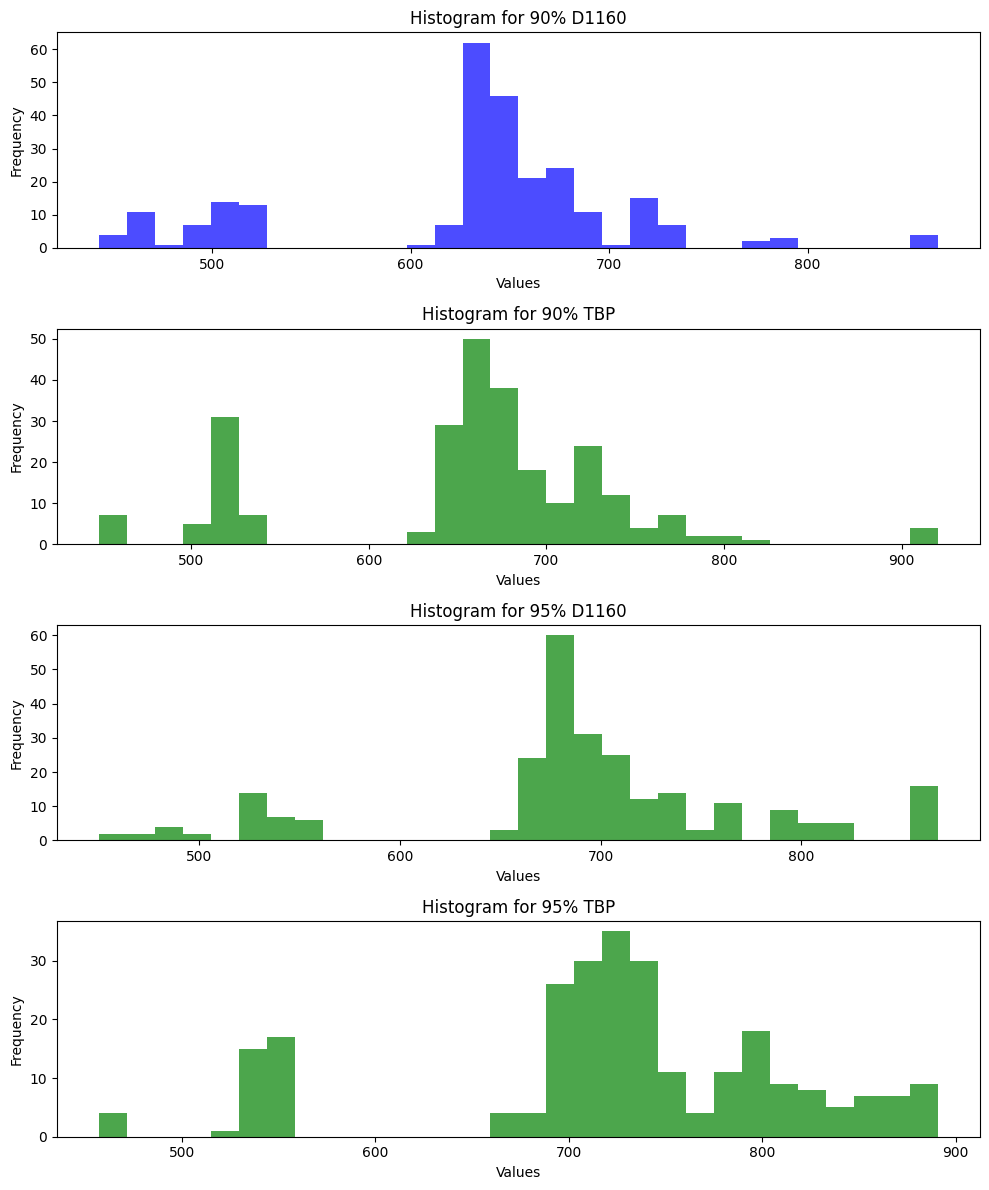

In [10]:
#let's plot it back
# Plot histograms for each column
plt.figure(figsize=(10, 12))

# Histogram for D1160 90 wt%
plt.subplot(4, 1, 1)
plt.hist(df90_new['D1160_90'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram for 90% D1160')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogram for TBP 90 wt%
plt.subplot(4, 1, 2)
plt.hist(df90_new['Target_90'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 90% TBP')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Histogram for TBP 90 wt%
plt.subplot(4, 1, 3)
plt.hist(df95_new['D1160_95'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 95% D1160')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.subplot(4, 1, 4)
plt.hist(df95_new['Target_95'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for 95% TBP')
plt.xlabel('Values')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()


In [11]:
#alright, now the data is normally distributed, let's fit this into the model
X90n = df90_new.drop('Target_90',axis=1)
y90n = df90_new['Target_90']

X95n = df95_new.drop('Target_95',axis=1)
y95n = df95_new['Target_95']

#split our data
X90n_train,X90n_test,y90n_train,y90n_test = train_test_split(X90n,y90n,
                                                             test_size= 0.1,
                                                             random_state =527)
X95n_train,X95n_test,y95n_train,y95n_test = train_test_split(X95n,y95n,
                                                             test_size= 0.1,
                                                             random_state =527)

#fit the data to model
reg90n =LinearRegression()
reg90n.fit(X90n_train,y90n_train)

reg95n =LinearRegression()
reg95n.fit(X95n_train,y95n_train)

LinearRegression()

In [12]:
#let's look at the accuracy
#make predictions
pred90n = reg90n.predict(X90n_test)
pred95n = reg95n.predict(X95n_test)

#check accuracy
from sklearn.metrics import r2_score,mean_squared_error

r290n = r2_score(pred90n,y90n_test)
mse90n =mean_squared_error(pred90n,y90n_test)

r295n = r2_score(pred95n,y95n_test)
mse95n =mean_squared_error(pred95n,y95n_test)


print(f"The new R2 score for 90 wt% is {r290n:0.04f}")
print(f"The new mean squared error for 90 wt% is {mse90n:0.04f}")

print(f"The new R2 score for 95 wt% is {r295n:0.04f}")
print(f"The new mean squared error for 95 wt% is {mse95n:0.04f}")

The new R2 score for 90 wt% is 0.9492
The new mean squared error for 90 wt% is 365.7387
The new R2 score for 95 wt% is 0.8841
The new mean squared error for 95 wt% is 703.9829
